In [1]:
import os
import pickle
import numpy as np
import pandas as pd

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wesad-2labels/2_labels.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dropout, Dense, Flatten
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit

2024-03-13 10:36:42.775517: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 10:36:42.775647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 10:36:42.897361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

merged_data = pd.read_csv(r"/kaggle/input/wesad-2labels/2_labels.csv")



In [6]:
X = merged_data.iloc[:, :-1].values
y = merged_data.iloc[:, -1].values
print(np.unique(y))



[1. 2.]


In [7]:
y[y == 1] = 0
y[y == 2] = 1

In [8]:
print(np.unique(y))

[0. 1.]


In [9]:
X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.8, random_state=42)

In [10]:
model = Sequential()

# CNN layers
model.add(Conv1D(filters=128, kernel_size=3, activation='relu' , input_shape=(X.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))

# Bilstm layer with dropout
model.add(Bidirectional(LSTM(256, return_sequences=False)))
model.add(Dropout(0.4))

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [11]:
history = model.fit(X_train, y_train, epochs=15, batch_size=1024, validation_data=(X_val, y_val))

Epoch 1/15
15082/15082 ━━━━━━━━━━━━━━━━━━━━ 197s 13ms/step - accuracy: 0.9666 - loss: 0.0797 - val_accuracy: 0.9980 - val_loss: 0.0066
Epoch 2/15
15082/15082 ━━━━━━━━━━━━━━━━━━━━ 190s 13ms/step - accuracy: 0.9965 - loss: 0.0108 - val_accuracy: 0.9976 - val_loss: 0.0070
Epoch 3/15
15082/15082 ━━━━━━━━━━━━━━━━━━━━ 190s 13ms/step - accuracy: 0.9976 - loss: 0.0076 - val_accuracy: 0.9959 - val_loss: 0.0101
Epoch 4/15
15082/15082 ━━━━━━━━━━━━━━━━━━━━ 191s 13ms/step - accuracy: 0.9980 - loss: 0.0063 - val_accuracy: 0.9970 - val_loss: 0.0081
Epoch 5/15
15082/15082 ━━━━━━━━━━━━━━━━━━━━ 193s 13ms/step - accuracy: 0.9984 - loss: 0.0050 - val_accuracy: 0.9991 - val_loss: 0.0033
Epoch 6/15
15082/15082 ━━━━━━━━━━━━━━━━━━━━ 192s 13ms/step - accuracy: 0.9986 - loss: 0.0043 - val_accuracy: 0.9994 - val_loss: 0.0019
Epoch 7/15
15082/15082 ━━━━━━━━━━━━━━━━━━━━ 193s 13ms/step - accuracy: 0.9986 - loss: 0.0044 - val_accuracy: 0.9955 - val_loss: 0.0099
Epoch 8/15
15082/15082 ━━━━━━━━━━━━━━━━━━━━ 192s 13ms/s

In [ ]:

model.save('wesad2-class.h5')


In [15]:
from sklearn.metrics import classification_report
predict_x=model.predict(X_test)
y_pred=np.argmax(predict_x,axis=1)
from sklearn.metrics import roc_curve, auc, roc_auc_score

96520/96520 ━━━━━━━━━━━━━━━━━━━━ 183s 2ms/step


In [24]:

print(f"Classification Report: \n{classification_report(y_test, y_pred)}")



96520/96520 ━━━━━━━━━━━━━━━━━━━━ 187s 2ms/step
Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1971490
         1.0       1.00      1.00      1.00   1117135

    accuracy                           1.00   3088625
   macro avg       1.00      1.00      1.00   3088625
weighted avg       1.00      1.00      1.00   3088625



Confusion Matrix for (0->1, 1->2):



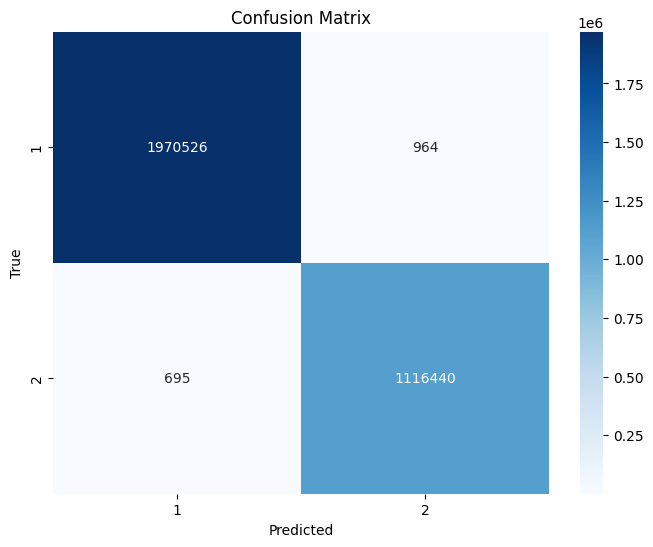

ROC for :



IndexError: index 1 is out of bounds for axis 1 with size 1

In [25]:

print(f"Confusion Matrix for (0->1, 1->2):\n")

def plot_confusion_matrix(y_true, y_pred, classes):
  y_true_remapped = np.where(y_true == 0, 1, 2)
  y_pred_remapped = np.where(y_pred == 0, 1, 2)
  cm = confusion_matrix(y_true_remapped, y_pred_remapped)
  
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

y_pred_prob = predict_x
y_pred = np.argmax(y_pred_prob, axis=1)
plot_confusion_matrix(y_test, y_pred, classes=['1', '2'])



Training and Validation Curves


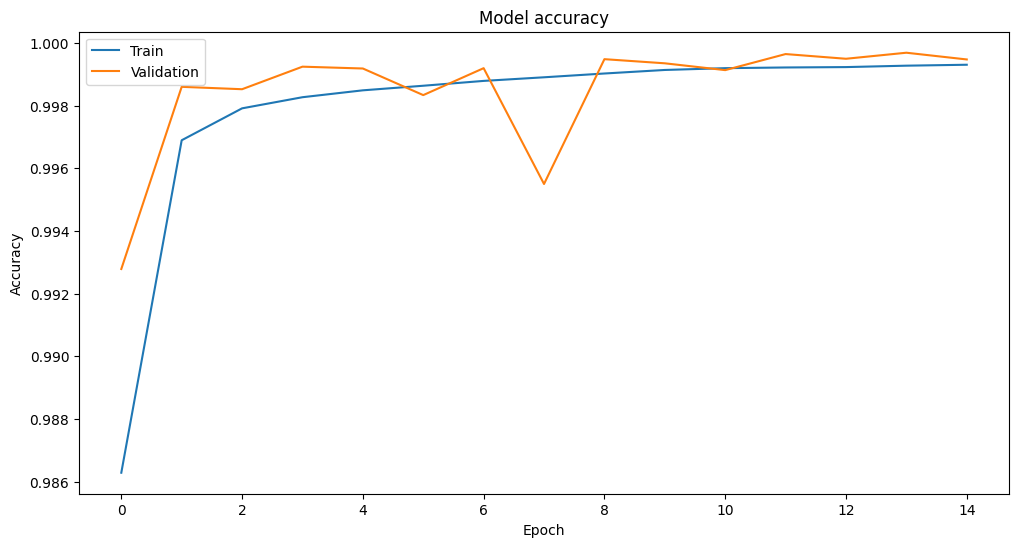

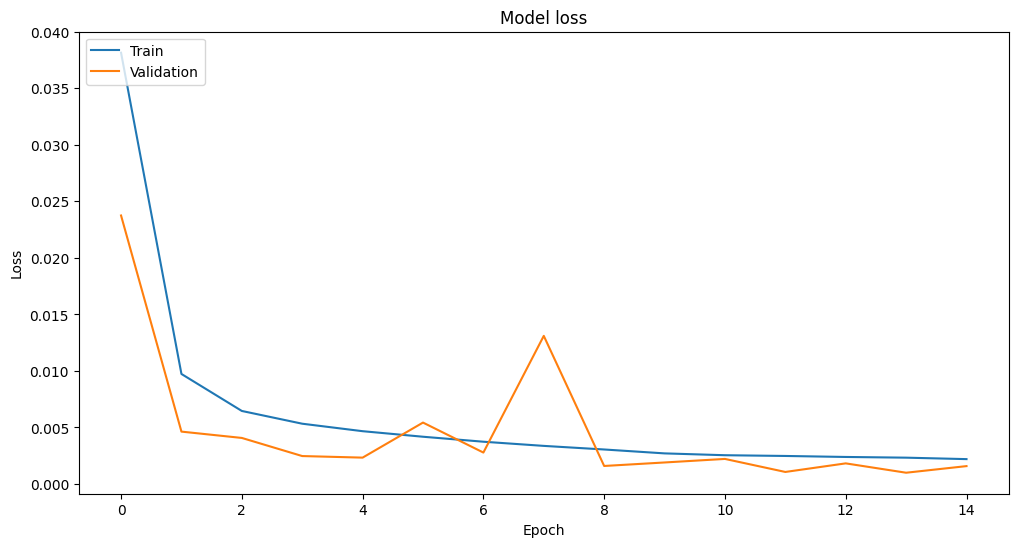

In [26]:
print(f"Training and Validation Curves")
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

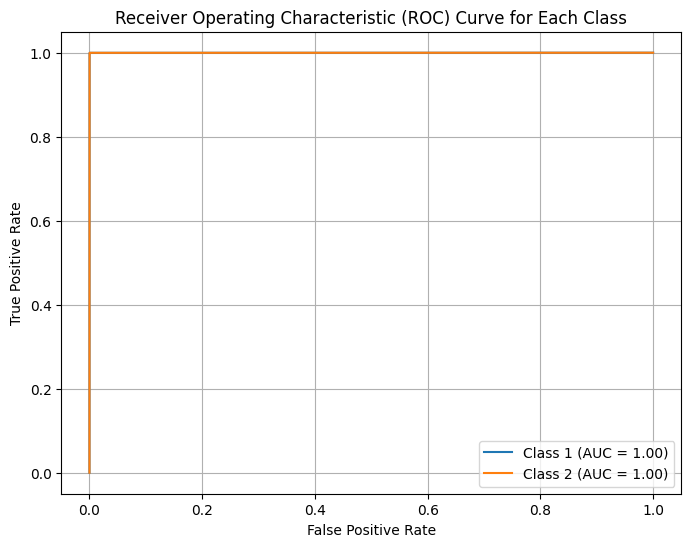

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(2):
    fpr, tpr, _ = roc_curve(y_test, predict_x[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {roc_auc:.2f})')


plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)